In [69]:
# Import libraries
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import altair as alt
import warnings

# Filter out Altair FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module='altair')

## Load Data

In [49]:
national_df = pd.read_csv("Data/national_data.csv")
states_df = pd.read_csv("Data/states_data.csv")

## diff from previous year (velocity) and acceleration
If there is a gap in years, which occurs for unusual names, just show the diff from two years ago.

In [50]:
national_df = national_df.sort_values(['sex','name','year'])
national_df['diff'] = national_df.groupby(['sex','name'])['count'].diff()
national_df.head(12)

,name,sex,count,year,diff
1705823,Aabha,F,7,2011,NaN
1743272,Aabha,F,5,2012,-2.0
1804465,Aabha,F,9,2014,4.0
1839808,Aabha,F,7,2015,-2.0
1872845,Aabha,F,7,2016,0.0
1971703,Aabha,F,6,2019,-1.0
2005105,Aabha,F,5,2020,-1.0
2036774,Aabha,F,5,2021,0.0
2068457,Aabha,F,5,2022,0.0
1941370,Aabidah,F,5,2018,NaN


In [51]:
national_df['accel'] = national_df.groupby(['sex','name'])['diff'].diff()
national_df.head(12)

,name,sex,count,year,diff,accel
1705823,Aabha,F,7,2011,NaN,NaN
1743272,Aabha,F,5,2012,-2.0,NaN
1804465,Aabha,F,9,2014,4.0,6.0
1839808,Aabha,F,7,2015,-2.0,-6.0
1872845,Aabha,F,7,2016,0.0,2.0
1971703,Aabha,F,6,2019,-1.0,-1.0
2005105,Aabha,F,5,2020,-1.0,0.0
2036774,Aabha,F,5,2021,0.0,1.0
2068457,Aabha,F,5,2022,0.0,0.0
1941370,Aabidah,F,5,2018,NaN,NaN


## 2-year changes?
A jump that occurs between January and December will be more noticeable than a jump that occurs between July and June. They are both 12 months but the second jump will be spread over two rows.
* do we care?
* show 2-year counts and differences?
* show differences from 2 years ago?
* other methods?

## Add percentage of birth records?

In [52]:
year_count = national_df[['year', 'count']].groupby('year').sum().reset_index()
dfn2 = pd.merge(national_df, year_count, on="year", suffixes=('', '_all'))
dfn2['perc'] = 100*dfn2['count']/dfn2['count_all']
dfn2.head()

,name,sex,count,year,diff,accel,count_all,perc
0,Aabha,F,7,2011,NaN,NaN,3656309,0.000191
1,Aabha,F,5,2012,-2.0,NaN,3655713,0.000137
2,Aabha,F,9,2014,4.0,6.0,3704186,0.000243
3,Aabha,F,7,2015,-2.0,-6.0,3698388,0.000189
4,Aabha,F,7,2016,0.0,2.0,3665860,0.000191


In [53]:
# test
dfn2[['year','perc']].groupby(['year']).sum().sample(5)

,perc
year,
1937,100.0
2004,100.0
1938,100.0
1964,100.0
1973,100.0


## Calculate differences versus std dev
Example: call it a jump (or drop) if the next year is >n standard deviations from the mean of the previous 10 years

We can play with different time spans (versus 10 years)

In [54]:
num_previous_years = 10

dfn2 = dfn2.sort_values(by=['name', 'sex', 'year'])

# dfn2['perc_change'] = dfn2.groupby(['name','sex'])['perc'].diff()

# note: min_periods=10 means that there won;t be calculations if there are not 10 previous years
# note: shift(1) means the current year is notr included ion the average and std dev
dfn2['10yr_ave'] = dfn2.groupby(['name','sex'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).mean().shift(1))
dfn2['10yr_std'] = dfn2.groupby(['name','sex'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).std().shift(1))
dfn2['10yr_z_score'] = dfn2['diff'] / dfn2['10yr_std']

dfn2.head()

,name,sex,count,year,diff,accel,count_all,perc,10yr_ave,10yr_std,10yr_z_score
1227795,Aaban,M,5,2007,NaN,NaN,3996648,0.000125,NaN,NaN,NaN
1227796,Aaban,M,6,2009,1.0,NaN,3818823,0.000157,NaN,NaN,NaN
1227797,Aaban,M,9,2010,3.0,2.0,3694428,0.000244,NaN,NaN,NaN
1227798,Aaban,M,11,2011,2.0,-1.0,3656309,0.000301,NaN,NaN,NaN
1227799,Aaban,M,11,2012,0.0,-2.0,3655713,0.000301,NaN,NaN,NaN


In [55]:
# I copied the data for Aaden (M) into Excel and verified the calculations worked as expected 
dfn2.iloc[108:129,:]

,name,sex,count,year,diff,accel,count_all,perc,10yr_ave,10yr_std,10yr_z_score
21,Aaden,F,5,2009,NaN,NaN,3818823,0.000131,NaN,NaN,NaN
1227882,Aaden,M,7,2001,NaN,NaN,3743094,0.000187,NaN,NaN,NaN
1227883,Aaden,M,13,2002,6.0,NaN,3737794,0.000348,NaN,NaN,NaN
1227884,Aaden,M,20,2003,7.0,1.0,3801760,0.000526,NaN,NaN,NaN
1227885,Aaden,M,21,2004,1.0,-6.0,3820359,0.000550,NaN,NaN,NaN
1227886,Aaden,M,33,2005,12.0,11.0,3844167,0.000858,NaN,NaN,NaN
1227887,Aaden,M,56,2006,23.0,11.0,3955317,0.001416,NaN,NaN,NaN
1227888,Aaden,M,157,2007,101.0,78.0,3996648,0.003928,NaN,NaN,NaN
1227889,Aaden,M,957,2008,800.0,699.0,3929428,0.024355,NaN,NaN,NaN
1227890,Aaden,M,1268,2009,311.0,-489.0,3818823,0.033204,NaN,NaN,NaN


## Plot some names that have had big drops and big jumps

In [56]:
z1 = dfn2.sort_values(by=['10yr_z_score']).head(2)
z1['type']='z-score drop'
z1

,name,sex,count,year,diff,accel,count_all,perc,10yr_ave,10yr_std,10yr_z_score,type
1408400,Damon,M,782,2006,-225.0,-240.0,3955317,0.019771,1018.8,22.074621,-10.192701,z-score drop
1122336,Tenzin,F,34,2020,-22.0,-25.0,3333981,0.001020,52.8,2.347576,-9.371370,z-score drop


In [57]:
z2 = dfn2.copy()
z2.replace([np.inf, -np.inf], np.nan, inplace=True)
z2 = z2[~pd.isnull(z2['10yr_z_score'])].sort_values(by=['10yr_z_score']).tail(2)
z2['type']='z-score jump'
z2

,name,sex,count,year,diff,accel,count_all,perc,10yr_ave,10yr_std,10yr_z_score,type
782,Aaliyah,F,1451,1994,1429.0,1432.0,3717356,0.039033,16.8,4.732864,301.931358,z-score jump
637424,Kizzie,F,286,1977,281.0,281.0,3176703,0.009003,5.7,0.823273,341.320723,z-score jump


In [58]:
z3 = dfn2.sort_values(by=['diff']).head(2)
z3['type']='overall drop'
z3

,name,sex,count,year,diff,accel,count_all,perc,10yr_ave,10yr_std,10yr_z_score,type
1648580,John,M,71519,1965,-11004.0,-14905.0,3625625,1.972598,78798.9,2157.577317,-5.100165,overall drop
709820,Linda,F,80431,1950,-10586.0,-5388.0,3503404,2.295796,53165.3,30848.704327,-0.343159,overall drop


In [59]:
z4 = dfn2[~pd.isnull(dfn2['diff'])].sort_values(by=['diff']).tail(2)
z4['type']='overall jump'
z4

,name,sex,count,year,diff,accel,count_all,perc,10yr_ave,10yr_std,10yr_z_score,type
1060984,Shirley,F,42359,1935,19516.0,10991.0,2089819,2.026922,14519.7,3242.354941,6.019082,overall jump
709817,Linda,F,99693,1947,46983.0,35735.0,3602222,2.767542,26686.6,16370.735314,2.869938,overall jump


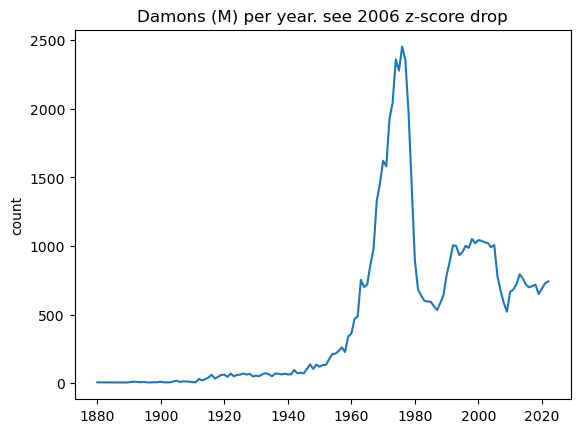

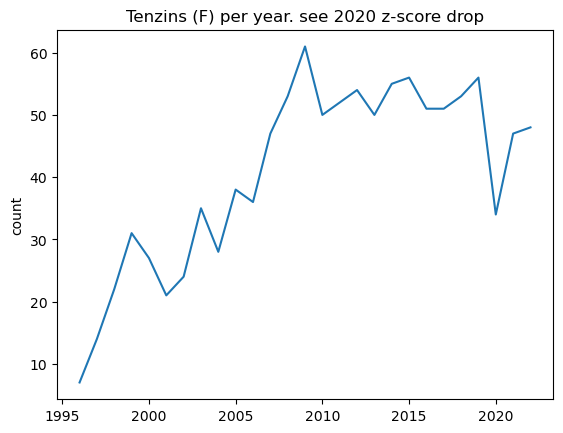

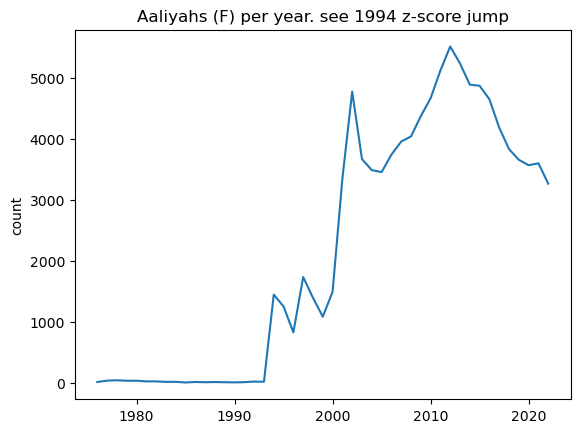

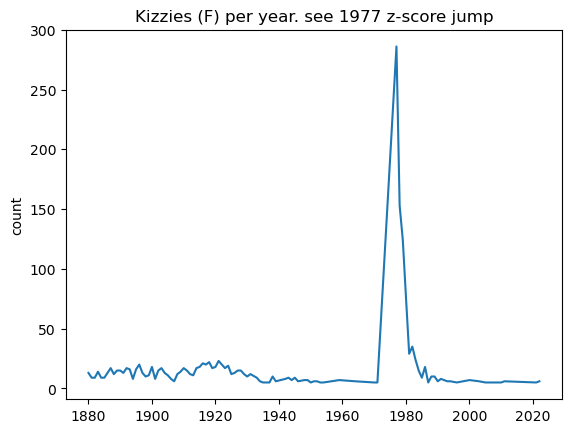

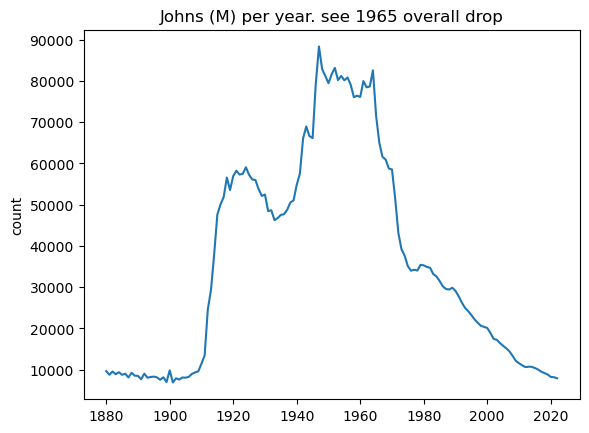

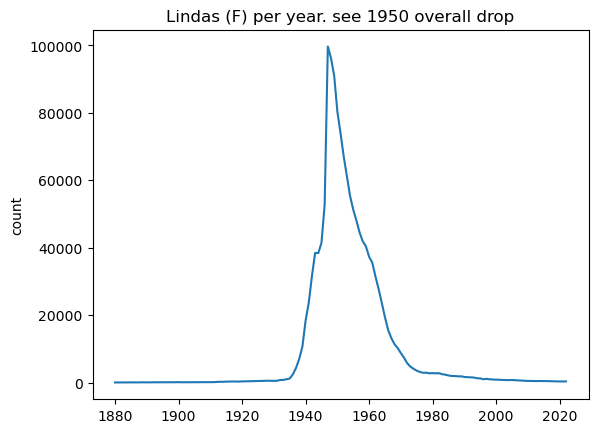

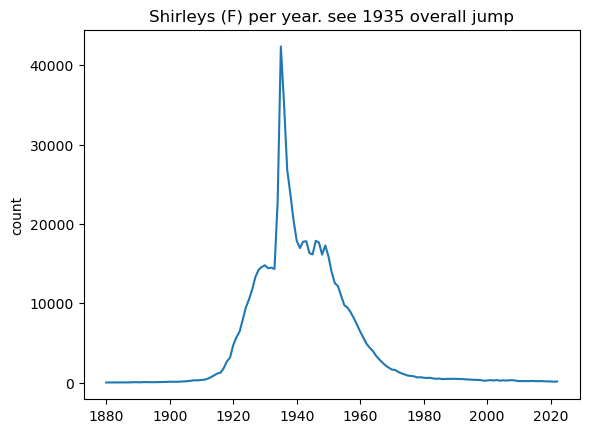

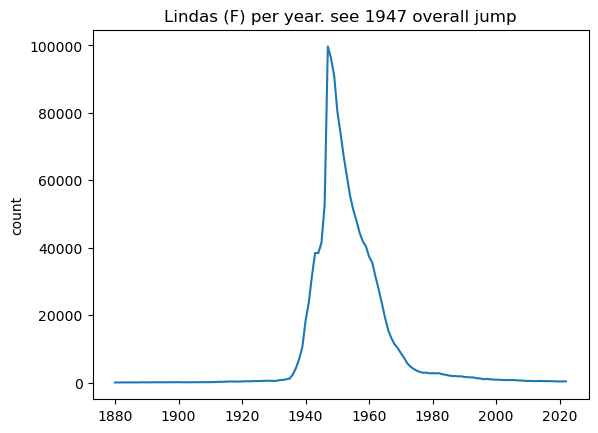

In [60]:

z5 = pd.concat([z1, z2, z3, z4], axis=0)
# z3
for ind in z5.index:
    name = z5.name[ind]
    sex = z5.sex[ind]
    yr = z5.year[ind]
    typ = z5.type[ind]
    
    z = dfn2.loc[(dfn2['name']==name) & (dfn2['sex']==sex)].sort_values(['year'])
    plt.plot(z['year'], z['count'])
    plt.ylabel('count')
    plt.title(name + 's (' + sex + ') per year. see ' + str(yr) + ' ' + typ)
    plt.show()    
    


Linda showed up twice in this small sample, 1947 jump and 1950 drop.

https://en.wikipedia.org/wiki/Linda_(1946_song)

https://www.youtube.com/watch?v=Ej2HuRw8dlg

per chatGPT:
"
The popularity of the name Linda in the United States around 1947 and its subsequent decline by 1950 can be attributed to cultural influences, particularly the impact of media and entertainment. In this case, the rise in popularity of the name Linda is often linked to the success of the song "Linda," written by Jack Lawrence. The song was originally penned in 1946 for the daughter of Lawrence's attorney, Lee Eastman, whose daughter was Linda McCartney, later known to be the wife of Paul McCartney of The Beatles. However, the song didn't become widely popular until it was recorded by Buddy Clark in 1947.

The song "Linda" became a massive hit, reaching the top of the charts. This exposure contributed to the name's popularity, as people were influenced by popular culture and the media to name their daughters Linda. It's a common phenomenon for names to rise in popularity due to their association with celebrities, characters in movies, TV shows, books, or songs that capture the public's imagination.

The decline in popularity after 1950 might be attributed to the natural cycle of naming trends, where a name becomes so popular that it starts to feel dated or overly common, prompting parents to look for other names for their newborns. Additionally, as new cultural influences emerge and public attention shifts to other celebrities or media, the names that are associated with those new influences may start to rise in popularity, causing previous favorites to decline.

This pattern of names waxing and waning in popularity based on cultural influences and media exposure is a common trend observed in many societies.
"

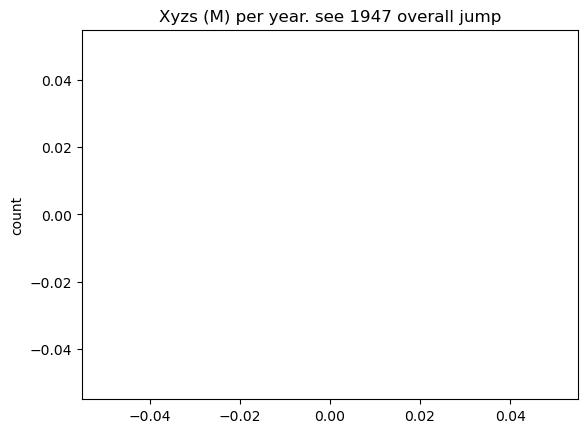

In [61]:
name, sex = 'Xyz', 'M'
z = dfn2.loc[(dfn2['name']==name) & (dfn2['sex']==sex)].sort_values(['year'])
plt.plot(z['year'], z['count'])
plt.ylabel('count')
plt.title(name + 's (' + sex + ') per year. see ' + str(yr) + ' ' + typ)
plt.show()    
    

### Name Statistics Over Time

In [102]:
#remove years prior to 1937
national_post1937_df = national_df[national_df['year']>1937]

In [105]:
first_known_year = national_post1937_df['year'].min()
last_known_year = national_post1937_df['year'].max()

In [106]:
def calculate_age_data(dataframe, first_known_year, last_known_year):
    """
    Calculate age for each year based on DataFrame and year range.
    
    Parameters:
        Dataframe: DataFrame containing all years of data
        first_known_year: The first year in the dataset
        last_known_year: last year in the dataset
        
    Returns:
        DataFrame: DataFrame containing age data for each year.
    """
    data = pd.DataFrame() #create empyt dataframe

    for year in range(first_known_year, last_known_year+1):
        df = dataframe[dataframe['year'] <= year].copy()
        df = df.sort_values(by='year')
        df['cumsum'] = df.groupby(['name', 'sex'])['count'].cumsum()
        df['sum'] = df.groupby(['name', 'sex'])['count'].transform('sum')
        medians = df[df['cumsum'] >= df['sum']/2].drop_duplicates(subset=['name', 'sex'], keep='first')
        medians['age'] = year - medians['year']
        thisyear = df[df['year'] == year][['name', 'sex', 'count']].rename(columns={'count': 'thisyear_count'})
        df = medians.merge(thisyear, how='left', on=['name', 'sex'])
        df['thisyear_count'] = df['thisyear_count'].fillna(0)
        df = df[['name', 'sex', 'sum', 'age', 'thisyear_count']]
        df['year'] = year
        data = pd.concat([data, df])

    data.reset_index(drop=True, inplace=True)  # Reset index
    
    return data


In [107]:
result_data = calculate_age_data(national_post1937_df[national_post1937_df['name'] == 'Sarah'], first_known_year, last_known_year)

In [108]:
result_data.head()

,name,sex,sum,age,thisyear_count,year
0,Sarah,F,3748,0,3748.0,1938
1,Sarah,M,22,0,22.0,1938
2,Sarah,F,7420,1,3672.0,1939
3,Sarah,M,40,1,18.0,1939
4,Sarah,F,11290,1,3870.0,1940


In [109]:

chart = alt.Chart(result_data).mark_circle().encode(
    x='age',
    y='thisyear_count',
    size='sum',
    order='year',
    tooltip=['name', 'sex', 'year', 'age', 'thisyear_count', 'sum'],
    color=alt.condition(alt.datum['M/F'] == 'F', alt.value('#FF69B4'), alt.value('pink'))  # Change color here
).properties(
    width=600,
    height=400,
    title='Chart Title'
)

chart = chart.configure_axis(
    labelFontSize=12,
    titleFontSize=12
)

# Display chart
chart


alt.Chart(...)